In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA



In [2]:
# Set some default parametres for plotting
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.rcParams['figure.figsize'] = (12,7)
#plt.style.use('ggplot')

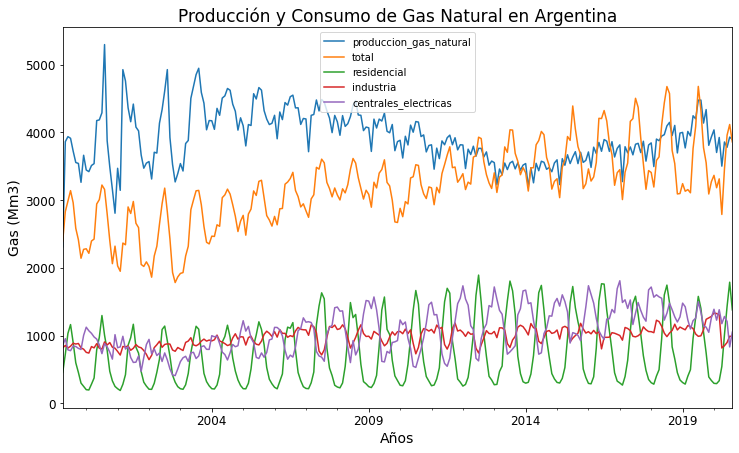

In [3]:
# Read data and drop NaN
df=pd.read_csv('exportaciones-actividad-saldocomercial-rangos-exportacion-empresa-exportadora-mensual.csv',index_col='indice_tiempo',parse_dates=True)
df.dropna(inplace= True)
# Delete irrelevant columns 
df.drop(columns=[ 'sdb', 'gnc',
       'metrogas', 'gas_natural_fenosa', 'distrib_gas_del_centro_ecogas',
       'distrib_gas_cuyana_ecogas', 'litoral_gas', 'gasnea', 'redengas',
       'gasnor', 'camuzzi_gas_pampeana', 'camuzzi_gas_del_sur','comercial','entes_oficiales'],inplace=True)
# Plot the data
fig,ax = plt.subplots()
df.plot(ax=ax)
ax.set(xlabel='Años',ylabel='Gas (Mm3)',title='Producción y Consumo de Gas Natural en Argentina')
ax.legend(loc='best')


In [4]:
df.columns

Index(['produccion_gas_natural', 'total', 'residencial', 'industria',
       'centrales_electricas'],
      dtype='object')

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 257 entries, 1999-04-01 to 2020-08-01
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   total      257 non-null    float64
 1   year       257 non-null    int64  
 2   month      257 non-null    object 
 3   timeIndex  257 non-null    int32  
 4   Aug        257 non-null    uint8  
 5   Dec        257 non-null    uint8  
 6   Feb        257 non-null    uint8  
 7   Jan        257 non-null    uint8  
 8   Jul        257 non-null    uint8  
 9   Jun        257 non-null    uint8  
 10  Mar        257 non-null    uint8  
 11  May        257 non-null    uint8  
 12  Nov        257 non-null    uint8  
 13  Oct        257 non-null    uint8  
 14  Sep        257 non-null    uint8  
dtypes: float64(1), int32(1), int64(1), object(1), uint8(11)
memory usage: 11.8+ KB


In [5]:
# Delete all columns except 'total' which is the total gas consumption per month
df.drop(columns=['produccion_gas_natural','residencial','industria','centrales_electricas' ],inplace=True)

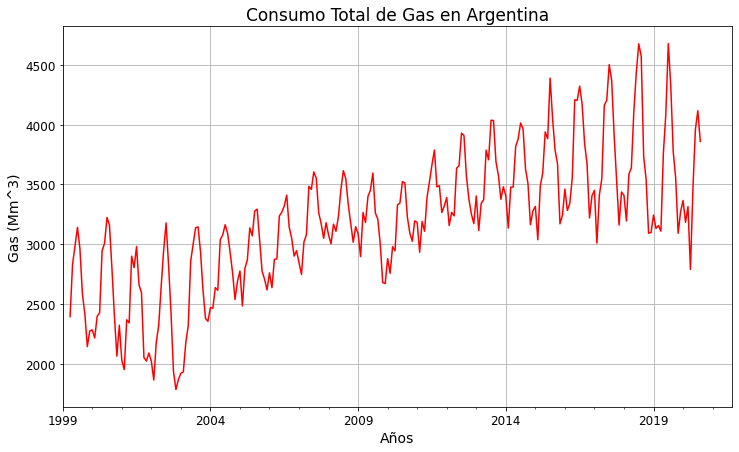

In [6]:
# Plot gas consumption 
fig,ax = plt.subplots()
df['total'].plot(color='r')
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina')
ax.set_xlim(left=348,right=620)
ax.grid(True)

In [7]:
ax.get_xlim()
ax.set_xlim(left=580)

(580.0, 620.0)

In [8]:
# Create month and year columns
df['year'] = [d.year for d in df.index]
df['month'] = [m.strftime('%b') for m in df.index]
df.head()

,total,year,month
indice_tiempo,,,
1999-04-01,2393.171,1999,Apr
1999-05-01,2831.401,1999,May
1999-06-01,2985.835,1999,Jun
1999-07-01,3140.439,1999,Jul
1999-08-01,2961.801,1999,Aug


In [9]:
# Create timeIndex variable
df['timeIndex'] = pd.Series(np.arange(len(df['total'])),index= df.index)
df.head()

,total,year,month,timeIndex
indice_tiempo,,,,
1999-04-01,2393.171,1999,Apr,0
1999-05-01,2831.401,1999,May,1
1999-06-01,2985.835,1999,Jun,2
1999-07-01,3140.439,1999,Jul,3
1999-08-01,2961.801,1999,Aug,4


In [10]:
# Create dummys for months and concat to data_wti
dummies_month = pd.get_dummies(df['month'],drop_first=True)
df = pd.concat([df,dummies_month],axis = 1)
df.head()

,total,year,month,timeIndex,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
indice_tiempo,,,,,,,,,,,,,,,
1999-04-01,2393.171,1999,Apr,0,0,0,0,0,0,0,0,0,0,0,0
1999-05-01,2831.401,1999,May,1,0,0,0,0,0,0,0,1,0,0,0
1999-06-01,2985.835,1999,Jun,2,0,0,0,0,0,1,0,0,0,0,0
1999-07-01,3140.439,1999,Jul,3,0,0,0,0,1,0,0,0,0,0,0
1999-08-01,2961.801,1999,Aug,4,1,0,0,0,0,0,0,0,0,0,0


In [11]:
# split the data set into train and test
from sklearn.model_selection import train_test_split

df_train,df_test = train_test_split(df,test_size=12,random_state=49,shuffle=False)
df_train

,total,year,month,timeIndex,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
indice_tiempo,,,,,,,,,,,,,,,
1999-04-01,2393.171,1999,Apr,0,0,0,0,0,0,0,0,0,0,0,0
1999-05-01,2831.401,1999,May,1,0,0,0,0,0,0,0,1,0,0,0
1999-06-01,2985.835,1999,Jun,2,0,0,0,0,0,1,0,0,0,0,0
1999-07-01,3140.439,1999,Jul,3,0,0,0,0,1,0,0,0,0,0,0
1999-08-01,2961.801,1999,Aug,4,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-01,3108.730,2019,Apr,240,0,0,0,0,0,0,0,0,0,0,0
2019-05-01,3761.735,2019,May,241,0,0,0,0,0,0,0,1,0,0,0
2019-06-01,4087.849,2019,Jun,242,0,0,0,0,0,1,0,0,0,0,0


In [12]:
len(df_train.index)

245

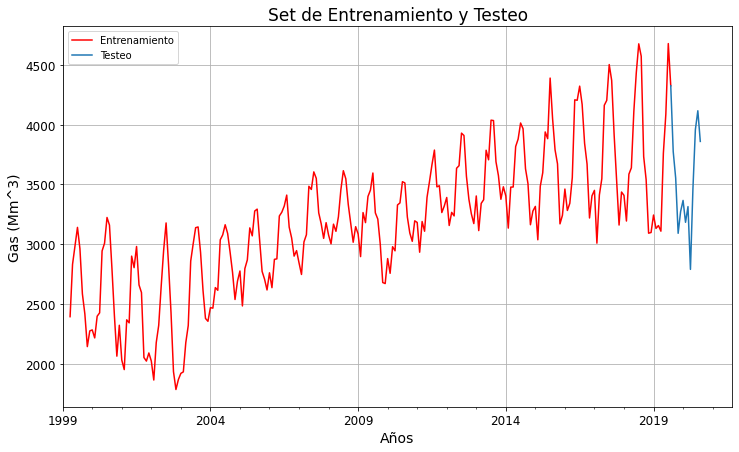

In [101]:
#Plot of train and test sets
train_plot = df['total'].iloc[0:len(df_train.index)]
test_plot = df['total'].iloc[len(df_train.index)-1:]
fig,ax = plt.subplots()
train_plot.plot(color='r',ax=ax,label = 'Entrenamiento')
test_plot.plot(ax=ax,color='tab:blue',label='Testeo')
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Set de Entrenamiento y Testeo')
ax.set_xlim(left=348,right=620)
ax.legend()
ax.grid(True)

In [14]:
# Function to calculate RMSE of any model
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [15]:
#First basic model : Mean
model_mean_pred = df_train['total'].mean()

# La predicción es fija y es la misma para el set de testeo y de entrenamiento:
df_train["Mean"] = model_mean_pred
df_test["Mean"] = model_mean_pred
model_mean_RMSE = RMSE(df_test['Mean'], df_test['total'])
model_mean_RMSE

488.0985169876933

<AxesSubplot:ylabel='Density'>

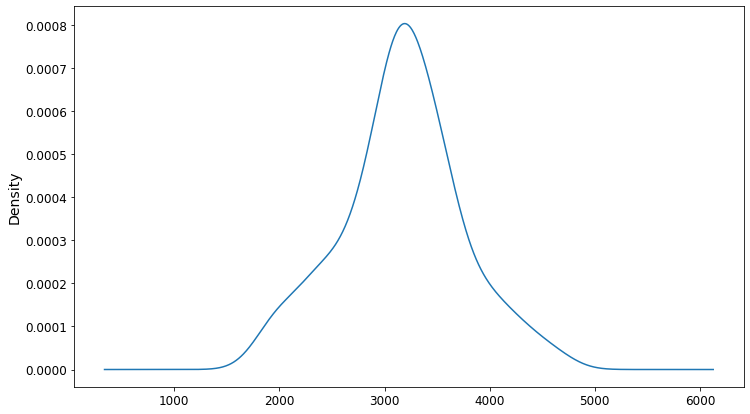

In [16]:
df_train['total'].plot(kind='kde')

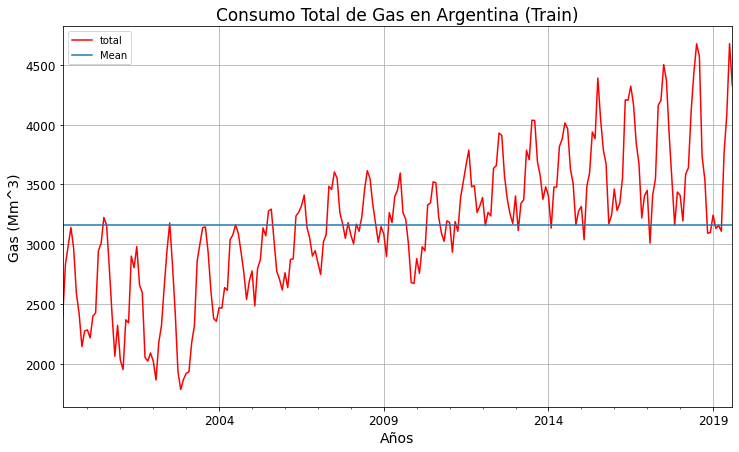

In [18]:
fig,ax = plt.subplots()
df_train.plot(kind = "line", y = ['total', 'Mean'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina (Train)')
ax.grid(True)

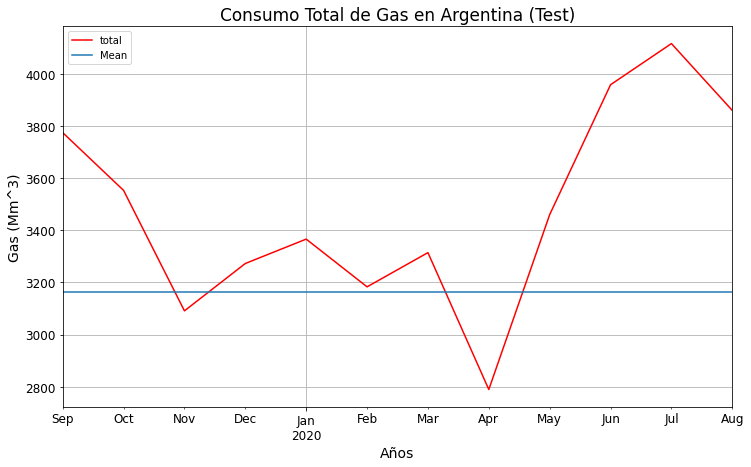

In [19]:
fig,ax = plt.subplots()
df_test.plot(kind = "line", y = ['total', 'Mean'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina (Test)')
ax.grid(True)

In [20]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])

# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior:
df_Results.loc[1, "Model"] = "Mean"
df_Results.loc[1, "RMSE"] = RMSE(df_test['Mean'], df_test['total'])
df_Results

,Model,RMSE
1,Mean,488.099


In [21]:
# Take the log od the serie 
df_train['log_total'] = np.log(df_train['total'])
df_test['log_total'] = np.log(df_test['total'])

In [22]:
# First regresion model only taking in consideration the timeIndex
model_log = smf.ols('log_total ~ timeIndex ', data = df_train).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_total   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     327.2
Date:                Wed, 17 Feb 2021   Prob (F-statistic):           6.59e-47
Time:                        14:01:55   Log-Likelihood:                 164.05
No. Observations:                 245   AIC:                            -324.1
Df Residuals:                     243   BIC:                            -317.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7942      0.016    491.945      0.000       7.763       7.825
timeIndex      0.0020      0.000     18.090      0.000       0.002       0.002
==============================================================================
Omnibus:                       11.760   Durbin-Watson:                   0.417
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.339
Skew:                          -0.548   Prob(JB):                      0.00209
Kurtosis:                       3.094   Cond. No.                         281.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
#Prediction of the train and the test sets
df_train['model_log'] = model_log.predict(df_train[["timeIndex"]])
df_test['model_log'] = model_log.predict(df_test[["timeIndex"]])

In [24]:
#back to original model
df_train['back_model_log'] = np.exp(df_train['model_log'])
df_test['back_model_log'] = np.exp(df_test['model_log'])

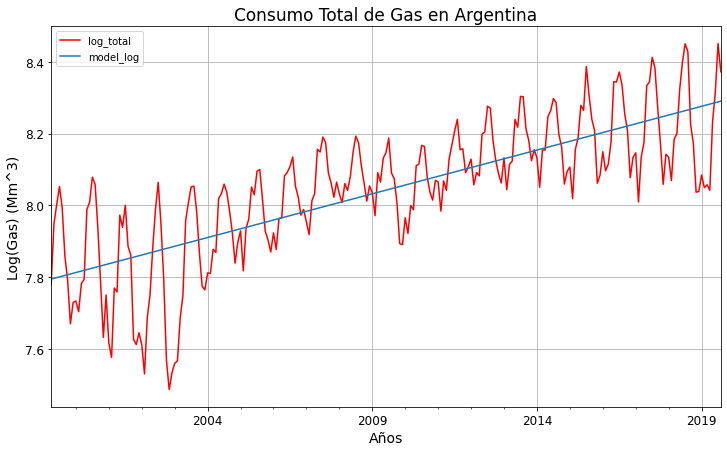

In [25]:
# Plot Log(gas) consumption 
fig,ax = plt.subplots()
df_train.plot(kind = "line", y = ['log_total', 'model_log'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Log(Gas) (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina')
ax.grid(True)

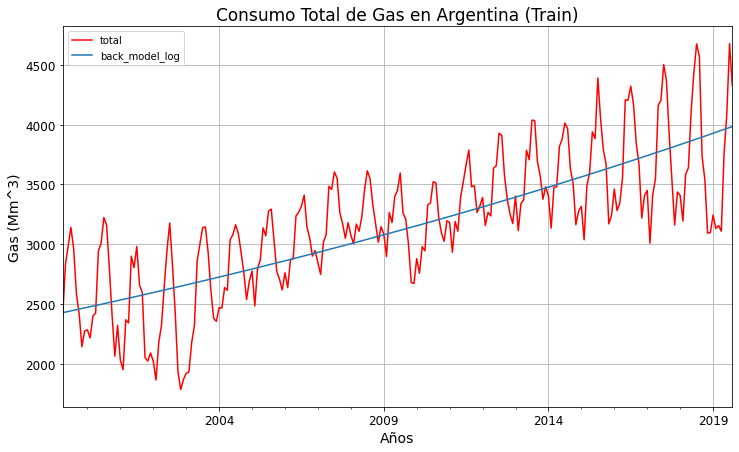

In [66]:
# Plot Log(gas) consumption 
fig,ax = plt.subplots()
df_train.plot(kind = "line", y = ['total', 'back_model_log'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina (Train)')
ax.grid(True)


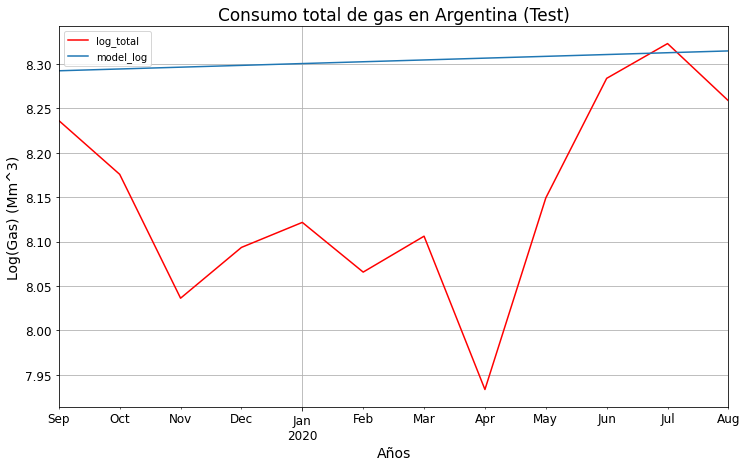

In [27]:
# Plot Log(gas) consumption predction on the test set
fig,ax = plt.subplots()
df_test.plot(kind = "line", y = ['log_total', 'model_log'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Log(Gas) (Mm^3)',xlabel= 'Años',title='Consumo total de gas en Argentina (Test)')
ax.grid(True)


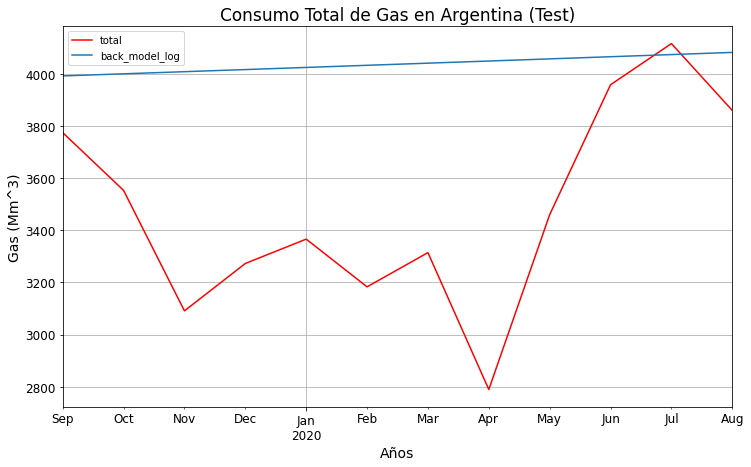

In [28]:
# Plot Log(gas) consumption predction on the test set
fig,ax = plt.subplots()
df_test.plot(kind = "line", y = ['total', 'back_model_log'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina (Test)')
ax.grid(True)

In [29]:


# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior:
df_Results.loc[2, "Model"] = "Transf Log"
df_Results.loc[2, "RMSE"] = RMSE(df_test['back_model_log'], df_test['total'])
df_Results

,Model,RMSE
1,Mean,488.099
2,Transf Log,667.076


## We add sesionality to the model

In [30]:
model_log_est = smf.ols('log_total ~ timeIndex + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

In [31]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_total   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     114.2
Date:                Wed, 17 Feb 2021   Prob (F-statistic):           3.95e-90
Time:                        14:01:56   Log-Likelihood:                 296.32
No. Observations:                 245   AIC:                            -566.6
Df Residuals:                     232   BIC:                            -521.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7529      0.018    428.862      0.000       7.717       7.789
timeIndex      0.0020    6.7e-05     30.321      0.000       0.002       0.002
Aug            0.1728      0.023      7.549      0.000       0.128       0.218
Dec           -0.0474      0.023     -2.045      0.042      -0.093      -0.002
Feb           -0.1013      0.023     -4.371      0.000      -0.147      -0.056
Jan           -0.0406      0.023     -1.753      0.081      -0.086       0.005
Jul            0.2066      0.023      9.023      0.000       0.161       0.252
Jun            0.1503      0.023      6.563      0.000       0.105       0.195
Mar           -0.0103      0.023     -0.442      0.659      -0.056       0.035
May            0.1297      0.023      5.667      0.000       0.085       0.175
Nov           -0.0776      0.023     -3.349      0.001      -0.123      -0.032
Oct            0.0063      0.023      0.273      0.785      -0.039       0.052
Sep            0.0840      0.023      3.625      0.000       0.038       0.130
==============================================================================
Omnibus:                       56.461   Durbin-Watson:                   0.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.907
Skew:                          -1.167   Prob(JB):                     2.24e-24
Kurtosis:                       5.286   Cond. No.                     1.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
#dropeo columnas sin significacion 
#df.drop(columns=['Oct','Mar','Jan'],axis=1,inplace=True)

In [67]:
# Refiteo el modelo
model_log_est = smf.ols('log_total ~ timeIndex + Aug +Dec +  Feb + Jul + Jun + May + Nov + Sep',\
                          data = df_train).fit()
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_total   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     150.7
Date:                Wed, 17 Feb 2021   Prob (F-statistic):           2.38e-92
Time:                        14:57:17   Log-Likelihood:                 293.84
No. Observations:                 245   AIC:                            -567.7
Df Residuals:                     235   BIC:                            -532.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7421      0.012    664.379      0.000       7.719       7.765
timeIndex      0.0020   6.73e-05     30.193      0.000       0.002       0.002
Aug            0.1839      0.018     10.082      0.000       0.148       0.220
Dec           -0.0364      0.019     -1.958      0.051      -0.073       0.000
Feb           -0.0903      0.019     -4.858      0.000      -0.127      -0.054
Jul            0.2176      0.018     11.933      0.000       0.182       0.254
Jun            0.1613      0.018      8.844      0.000       0.125       0.197
May            0.1407      0.018      7.718      0.000       0.105       0.177
Nov           -0.0666      0.019     -3.584      0.000      -0.103      -0.030
Sep            0.0950      0.019      5.111      0.000       0.058       0.132
==============================================================================
Omnibus:                       57.157   Durbin-Watson:                   0.366
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.971
Skew:                          -1.182   Prob(JB):                     1.32e-24
Kurtosis:                       5.276   Cond. No.                         874.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
model_log_est = smf.ols('total ~ timeIndex + Aug +Dec +  Feb + Jul + Jun + May + Nov + Sep',\
                          data = df_train).fit()
model_log_est.summary()

In [75]:
#Predict train and test with the model

df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", \
                                              "Aug",'Dec', "Feb",\
                                               "Jul", "Jun", "May",\
                                                "Nov", "Sep"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", \
                                              "Aug",'Dec', "Feb",\
                                               "Jul", "Jun", "May",\
                                                "Nov", "Sep"]])


In [76]:
#back log
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

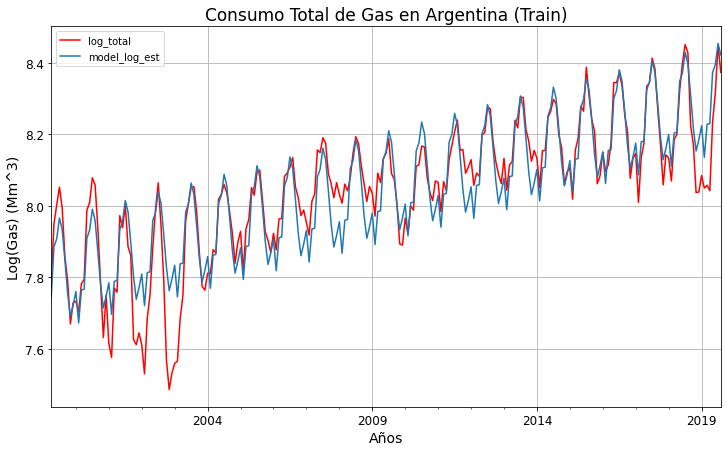

In [77]:
# Plot the prediction of the train set (log)
fig,ax = plt.subplots()
df_train.plot(kind = "line", y = ['log_total', 'model_log_est'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Log(Gas) (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina (Train)')
ax.grid(True)

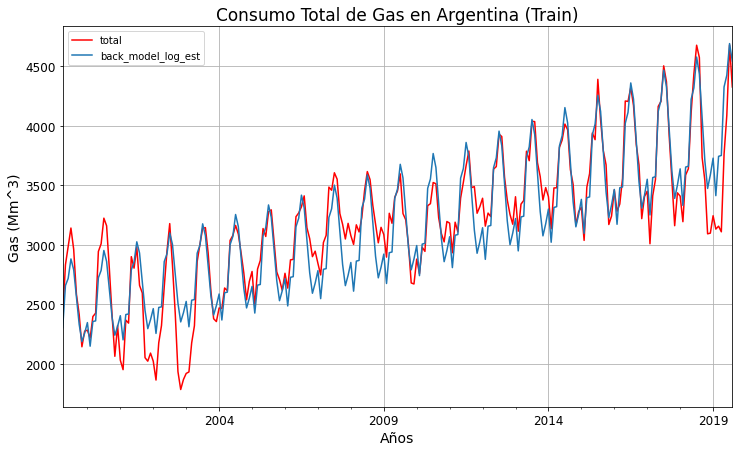

In [78]:
# Plot the prediction of the train set
fig,ax = plt.subplots()
df_train.plot(kind = "line", y = ['total', 'back_model_log_est'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina (Train)')
ax.grid(True)

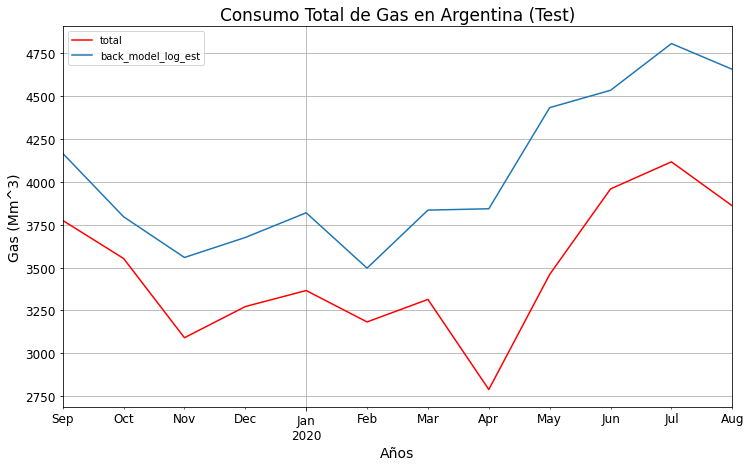

In [79]:
# Plot the prediction of the test set
fig,ax = plt.subplots()
df_test.plot(kind = "line", y = ['total', 'back_model_log_est'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina (Test)')
ax.grid(True)

In [80]:
df_Results.loc[3, "Model"] = "Transf Log + Est."
df_Results.loc[3, "RMSE"] = RMSE(df_test['back_model_log_est'], df_test['total'])
df_Results

,Model,RMSE
1,Mean,488.099
2,Transf Log,667.076
3,Transf Log + Est.,623.575


## We analize the resiuals to see if we can get any information

In [81]:
#Calculo los residuos
res_model = df_train['total'] - df_train['back_model_log_est']



In [82]:
def tsplot(y, lags=None,titulo='',ylegend='',ylabel=''):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    #if not isinstance(y, pd.Series):
    y = pd.Series(y)

#with plt.style.context(style):    
    fig = plt.figure()
    layout = (2, 2)

    # definimos ejes
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    # calculo la media movil
    rolling_mean = y.rolling(window=lags).mean()
    # ploteo la serie y la media movil
    y.plot(ax=ts_ax,label=f'{ylegend}',color='r')
    rolling_mean.plot(ax=ts_ax,label='Rolling Mean',color='k')
    ts_ax.legend()

    # obtengo el p-value con h0: raiz unitaria presente
    p_value = sm.tsa.stattools.adfuller(y)[1]

    #ts_ax.set(title='{}\n Dickey-Fuller: p={0:.5f}'\
                    #.format(p_value))

    # plot de autocorrelacion
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax,color='r')
    # plot de autocorrelacion parcial
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax,color='r')
    plt.tight_layout()
    
    ts_ax.set(title=f'{titulo}\n Dickey-Fuller: p={p_value:.5f}',xlabel='Años',ylabel=f'{ylabel}')
    
    acf_ax.set(xlabel='Lags')
    pacf_ax.set(xlabel='Lags')


    # Dickey–Fuller test:
    result = adfuller(y)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    if result[1] > 0.05:
        print('\nNo puedo rechazar la hipotesis nula de que la serie es no estacionaria\nya que p-value>0.05')
    else:
        print('\nRechazo la hipotesis nula de que la serie es no estacionaria\nya que p-value<0.05')



ADF Statistic: -1.4260504334733934
p-value: 0.5697254744408786
Critical Values:
	1%: -3.458854867412691
	5%: -2.8740800599399323
	10%: -2.573453223097503

No puedo rechazar la hipotesis nula de que la serie es no estacionaria
ya que p-value>0.05


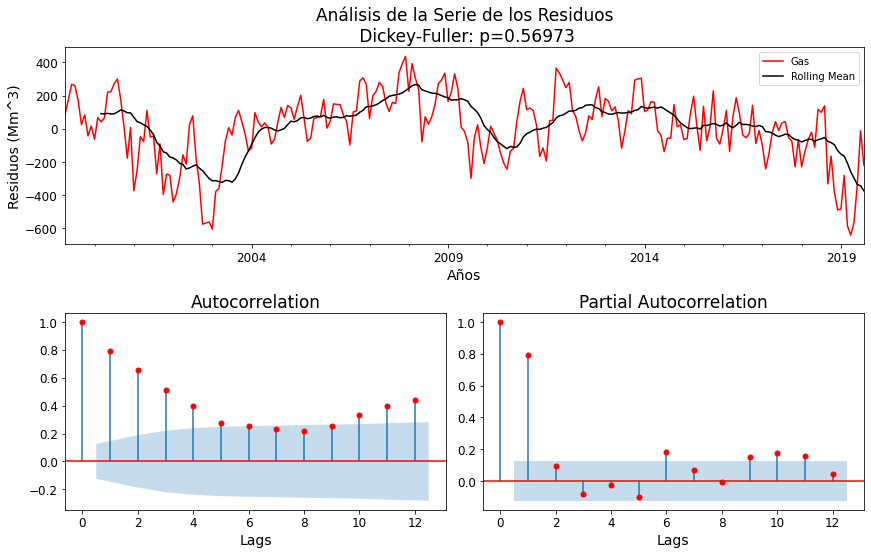

In [83]:
#Calculo los residuos
res_model = df_train['total'] - df_train['back_model_log_est']
#analizo si los residuos son o no estacionarios
tsplot(res_model,lags=12,titulo='Análisis de la Serie de los Residuos',ylegend='Gas',ylabel='Residuos (Mm^3)')

ADF Statistic: -1.8398986124571282
p-value: 0.36084066635652734
Critical Values:
	1%: -3.458854867412691
	5%: -2.8740800599399323
	10%: -2.573453223097503

No puedo rechazar la hipotesis nula de que la serie es no estacionaria
ya que p-value>0.05


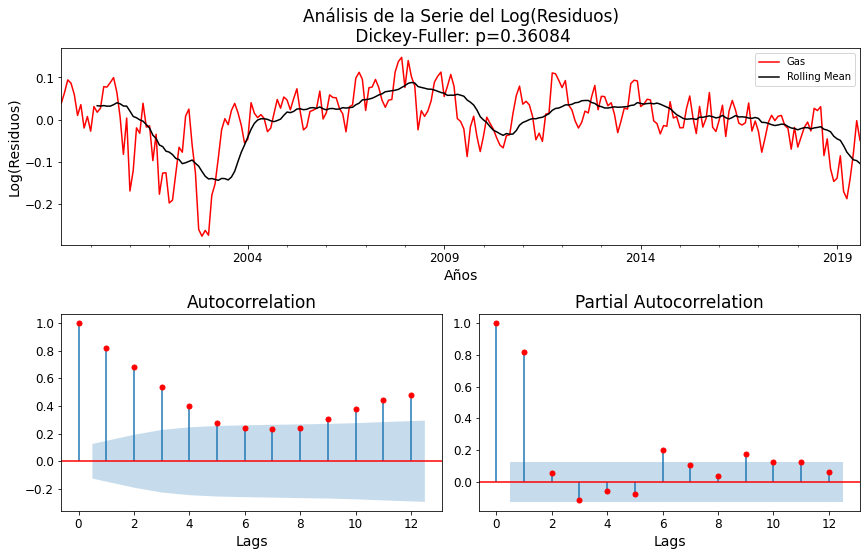

In [102]:
#analizo si el log de los residuos son o no estacionarios
res_log_est = df_train['log_total'] - df_train['model_log_est']
tsplot(res_log_est,lags=12,titulo='Análisis de la Serie del Log(Residuos)',ylegend='Gas',ylabel='Log(Residuos)')

In [85]:
#Analizo si la serie diferenciada de los residuos son o no estacionarios
res_log_est_diff = res_log_est.diff()

In [86]:
res_log_est_diff.dropna(inplace=True)

ADF Statistic: -5.596458371609426
p-value: 1.2937080113766471e-06
Critical Values:
	1%: -3.458854867412691
	5%: -2.8740800599399323
	10%: -2.573453223097503

Rechazo la hipotesis nula de que la serie es no estacionaria
ya que p-value<0.05


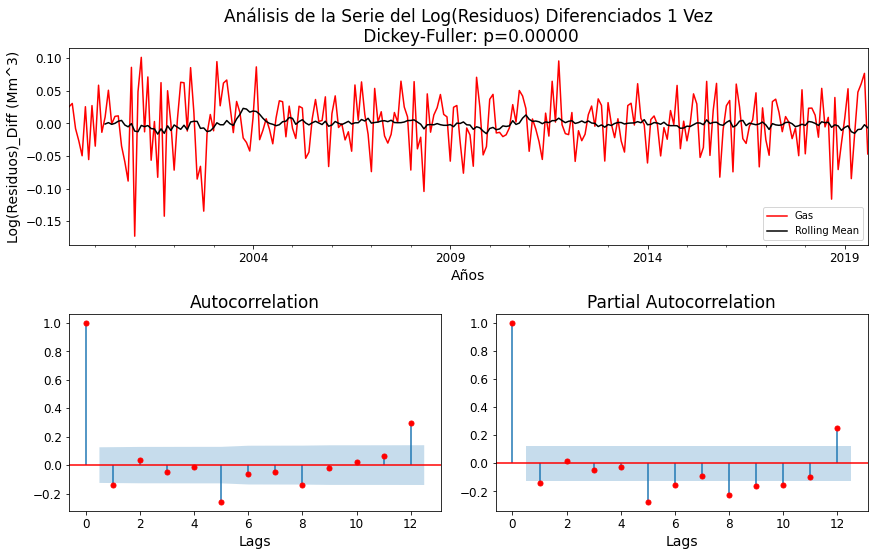

In [87]:
tsplot(res_log_est_diff,lags=12,titulo='Análisis de la Serie del Log(Residuos) Diferenciados 1 Vez',ylegend='Gas',ylabel='Log(Residuos)_Diff (Mm^3)')

In [108]:
#Fiteo el modelo
model_ARIMA = ARIMA(res_log_est, order=(5,1,5))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
print(results_ARIMA.summary())



C:\Users\hugo_\.conda\envs\dhdsblend\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hugo_\.conda\envs\dhdsblend\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hugo_\.conda\envs\dhdsblend\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  244
Model:                 ARIMA(5, 1, 5)   Log Likelihood                 447.245
Method:                       css-mle   S.D. of innovations              0.038
Date:                Wed, 17 Feb 2021   AIC                           -870.490
Time:                        21:18:01   BIC                           -828.524
Sample:                    05-01-1999   HQIC                          -853.588
                         - 08-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.565      0.572      -0.002       0.001
ar.L1.D.y      0.5645      0.124      4.555      0.000       0.322       0.807
ar.L2.D.y      0.4283      0.075      5.681      0.0

In [48]:
#results_ARIMA.plot_predict()

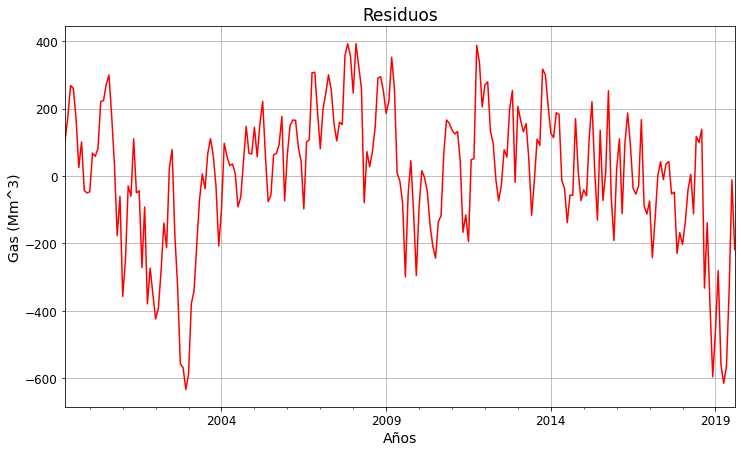

In [72]:
#plt.plot(res_log_est)
fig,ax = plt.subplots()
res_model.plot(ax=ax,color='r')
#results_ARIMA.fittedvalues.plot(ax=ax,label='Predicción ARIMA');
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Residuos')
ax.grid(True)
#ax.legend()

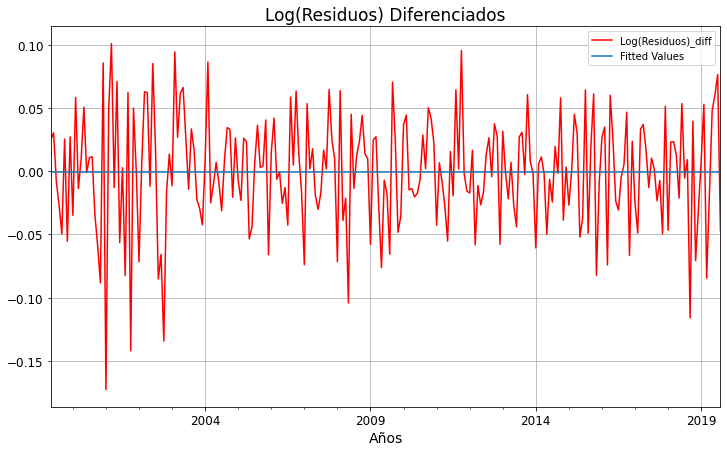

In [106]:
fig,ax = plt.subplots()
res_log_est_diff.plot(ax=ax,label='Log(Residuos)_diff',color='r')
results_ARIMA.fittedvalues.plot(ax=ax,label='Fitted Values');
ax.set(xlabel= 'Años',title='Log(Residuos) Diferenciados')
ax.grid(True)
ax.legend()

ADF Statistic: -15.646500233356686
p-value: 1.6160922124594876e-28
Critical Values:
	1%: -3.4575505077947746
	5%: -2.8735087323013526
	10%: -2.573148434859185

Rechazo la hipotesis nula de que la serie es no estacionaria
ya que p-value<0.05


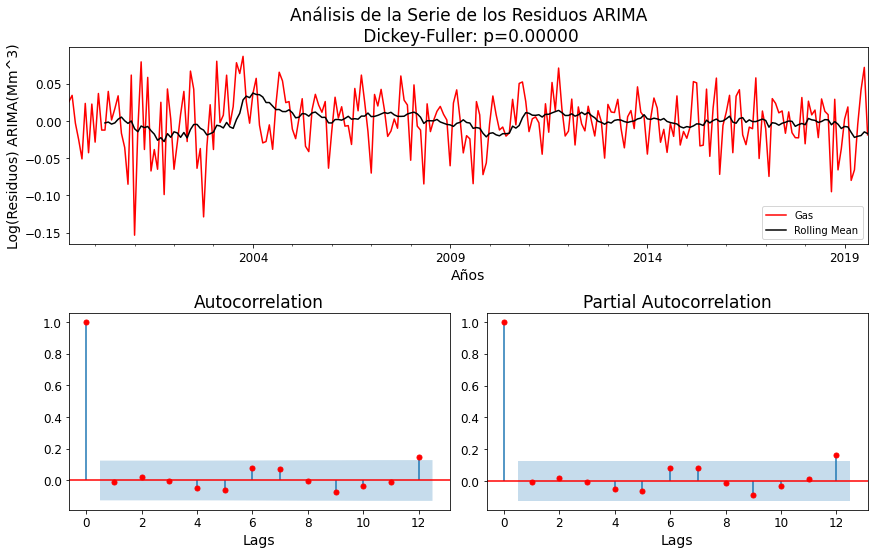

In [94]:
#Analizamos si los residuos son estacionarios

res_ARIMA = res_log_est_diff - results_ARIMA.fittedvalues
tsplot(res_ARIMA,lags=12,titulo='Análisis de la Serie de los Residuos ARIMA',ylegend='Gas',ylabel='Log(Residuos) ARIMA(Mm^3)')

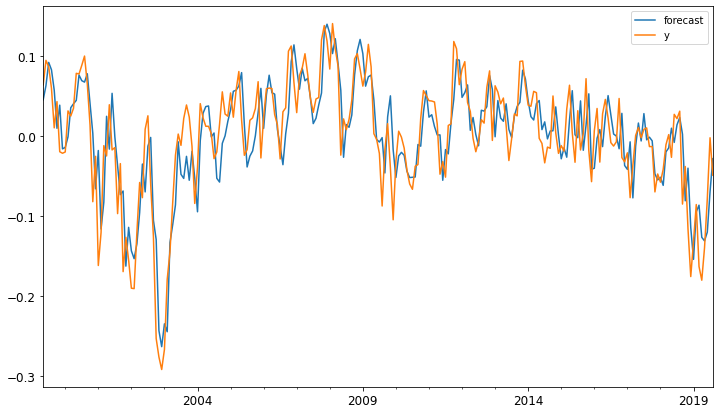

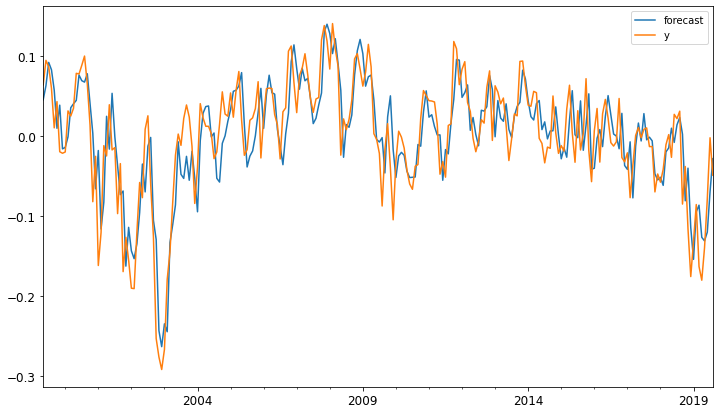

In [52]:
results_ARIMA.plot_predict()

In [53]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['total']), alpha=0.05)

In [54]:
df_train['log_model_ARIMA'] = df_train['model_log_est'] + results_ARIMA.fittedvalues

df_test['log_model_ARIMA'] = df_test['model_log_est'] + predictions_ARIMA

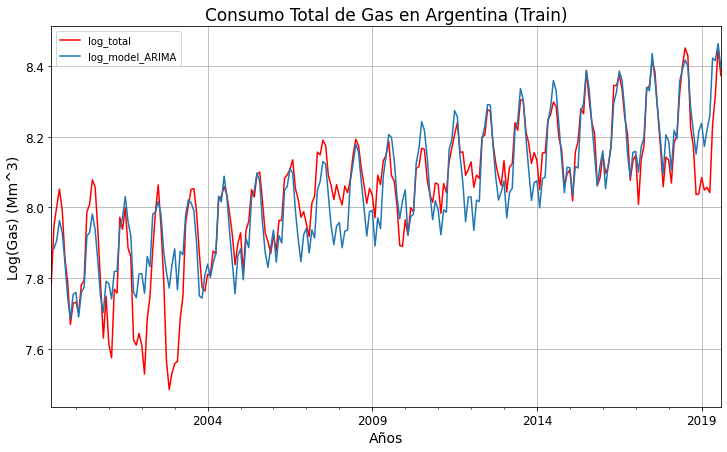

In [55]:


fig,ax = plt.subplots()
df_train.plot(kind = "line", y = ['log_total', 'log_model_ARIMA'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Log(Gas) (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina (Train)')
ax.grid(True)

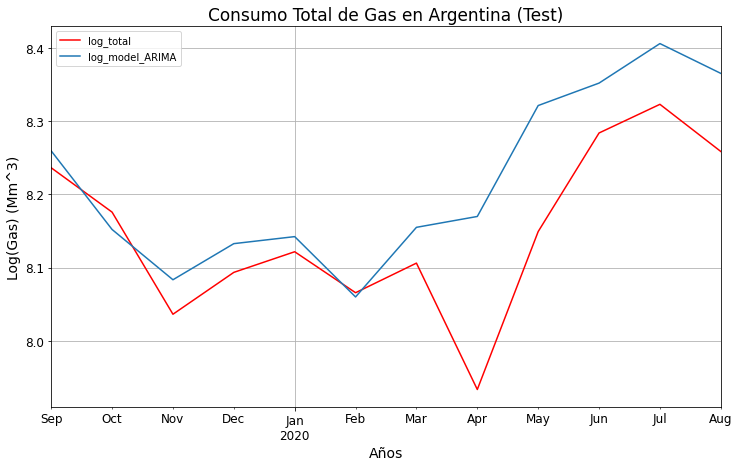

In [56]:
#df_test.plot(kind = "line", y = ['log_total', 'log_model_ARIMA']);

fig,ax = plt.subplots()
df_test.plot(kind = "line", y = ['log_total', 'log_model_ARIMA'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Log(Gas) (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina (Test)')
ax.grid(True)

In [57]:
df_train['back_log_model_ARIMA'] = np.exp(df_train['log_model_ARIMA'])

df_test['back_log_model_ARIMA'] = np.exp(df_test['log_model_ARIMA'])

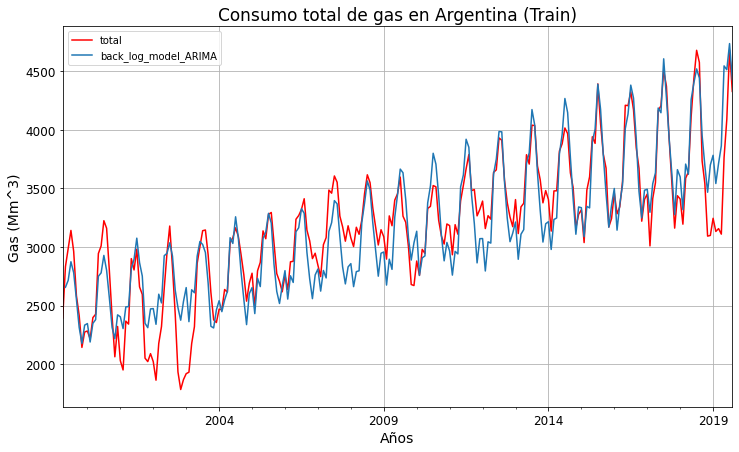

In [58]:
#df_train.plot(kind = "line", y = ['total', 'back_log_model_ARIMA']);

fig,ax = plt.subplots()
df_train.plot(kind = "line", y = ['total', 'back_log_model_ARIMA'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Consumo total de gas en Argentina (Train)')
ax.grid(True)

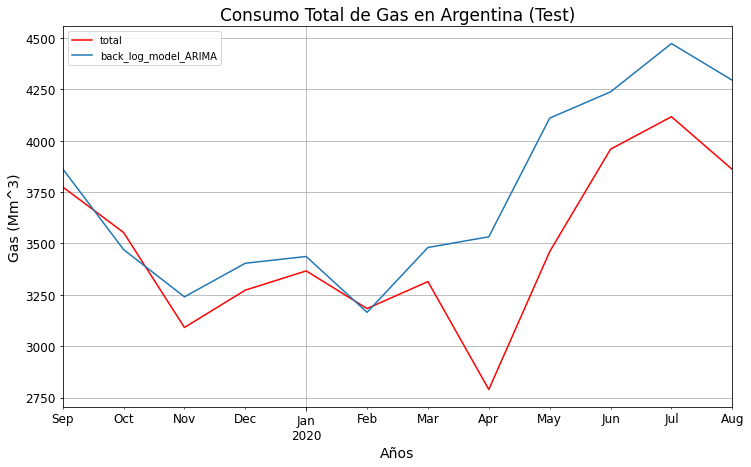

In [59]:
#df_test.plot(kind = "line", y = ['total', 'back_log_model_ARIMA']);
fig,ax = plt.subplots()
df_test.plot(kind = "line", y = ['total', 'back_log_model_ARIMA'],ax=ax,color=['r','tab:blue']);
ax.set(ylabel='Gas (Mm^3)',xlabel= 'Años',title='Consumo Total de Gas en Argentina (Test)')
ax.grid(True)

In [60]:
predictions_ARIMA

array([-0.07558922, -0.08267574, -0.09392258, -0.10607453, -0.09851258,
       -0.09978969, -0.08988888, -0.07709657, -0.07562687, -0.06753176,
       -0.07193887, -0.08091837])

In [96]:
df_Results.loc[4, "Model"] = "Log Model + est + ARIMA"
df_Results.loc[4, "RMSE"] = RMSE(df_test['back_log_model_ARIMA'], df_test['total'])
df_Results

,Model,RMSE
1,Mean,488.099
2,Transf Log,667.076
3,Transf Log + Est.,623.575
4,Log Model + est + ARIMA,348.163


In [62]:
df_test['back_log_model_ARIMA']

indice_tiempo
2019-09-01    3863.050274
2019-10-01    3470.031560
2019-11-01    3239.841881
2019-12-01    3403.578818
2020-01-01    3436.387284
2020-02-01    3164.683634
2020-03-01    3480.259947
2020-04-01    3532.234219
2020-05-01    4109.841950
2020-06-01    4237.733435
2020-07-01    4472.682182
2020-08-01    4294.334916
Name: back_log_model_ARIMA, dtype: float64

In [63]:
df_test['total']

indice_tiempo
2019-09-01    3774.989
2019-10-01    3553.227
2019-11-01    3090.854
2019-12-01    3272.681
2020-01-01    3366.155
2020-02-01    3183.032
2020-03-01    3314.301
2020-04-01    2788.990
2020-05-01    3460.125
2020-06-01    3958.721
2020-07-01    4116.687
2020-08-01    3859.982
Name: total, dtype: float64

In [64]:
df.index[0]

Timestamp('1999-04-01 00:00:00')

In [65]:
df.index[-1]

Timestamp('2020-08-01 00:00:00')

In [100]:
df_train.index[1]

Timestamp('1999-05-01 00:00:00')